In [10]:
from torchvision.datasets import VOCSegmentation
from torchvision.transforms.functional import to_tensor, to_pil_image
from PIL import Image
import torch
import numpy as np
from skimage.segmentation import mark_boundaries
import matplotlib.pylab as plt
import os
import time

%matplotlib inline

# VOCSegmentation dataset을 정의합니다.
class myVOCSegmentation(VOCSegmentation):
    def __getitem__(self, index):
        img = Image.open(self.images[index]).convert('RGB')
        target = Image.open(self.masks[index])

        if self.transforms is not None:
            augmented = self.transforms(image=np.array(img), mask=np.array(target))
            img = augmented['image']
            target = augmented['mask']
            target[target>20] = 0
        
        img = to_tensor(img)
        target = torch.from_numpy(target).type(torch.long)
        return img, target

In [3]:
num_classes = 21
COLORS = np.random.randint(0, 2, size=(num_classes+1,3), dtype='uint8')

# 이미지와 마스크를 함께 시각화하는 함수를 정의합니다.
def show_img_target(img, target):
    if torch.is_tensor(img):
        img=to_pil_image(img)
        target=target.numpy()
    for ll in range(num_classes):
        mask=(target==ll)
        img=mark_boundaries(np.array(img),mask,outline_color=COLORS[ll],color=COLORS[ll])
    plt.imshow(img)

In [4]:
# re-normalize 함수를 정의합니다.
def re_normalize(x, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)):
    x_r = x.clone()
    for c, (mean_c, std_c) in enumerate(zip(mean,std)):
        x_r[c] *= std_c
        x_r[c] += mean_c
    return x_r

In [5]:
import torch
import albumentations as albu
from albumentations.pytorch import ToTensorV2
from torchvision.utils import make_grid
from torchvision.utils import draw_segmentation_masks
import matplotlib.pyplot as plt
import torchvision.transforms.functional
from torch.utils.data import random_split

path2data = './data'

h,w = 256, 256

test_transform = albu.Compose([
    albu.Resize(height=h, width=w),
    # albu.RandomCrop(height=224, width=224),
    albu.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
])

test_dataset = myVOCSegmentation(root=path2data, year='2012', image_set='val', transforms=test_transform, download=True)

  0%|          | 0/1999639040 [00:00<?, ?it/s]

Extracting ./data/VOCtrainval_11-May-2012.tar to ./data


In [6]:
import torch.nn as nn

class ResNetBlock(nn.Module):
  def __init__(self, in_channels, out_channels, stride):
    super().__init__()
    self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                           kernel_size=3, padding=1, stride=stride, bias=False)
    self.bn1 = nn.BatchNorm2d(num_features=out_channels)
    self.conv2 = nn.Conv2d(in_channels=out_channels, out_channels=out_channels,
                         kernel_size=3, padding=1, stride=1, bias=False)
    self.bn2 = nn.BatchNorm2d(num_features=out_channels)
    self.relu = nn.ReLU()

    self.use_padding = (in_channels != out_channels)


  def forward(self, x):
    x1 = self.relu(self.bn1(self.conv1(x)))
    x2 = self.bn2(self.conv2(x1))

    if self.use_padding:
      # dimensions are not matched hence we need to use shortcut
      # tensor: BxCxHxW
      padding_shape = []
              
      for i in range(len(x.shape)-1, -1, -1):
        padding_shape.append((x2.shape[i] - x.shape[i])//2)
        padding_shape.append((x2.shape[i] - x.shape[i])//2)

      x = nn.functional.pad(x, padding_shape, "constant", 0)

    return self.relu(x2 + x)

class ResNetLayer(nn.Module):
  def __init__(self, in_channels, out_channels, first_stride, N=3):
    super().__init__()
    layers = [
        ResNetBlock(in_channels=in_channels, out_channels=out_channels, stride=first_stride)
    ]

    for _ in range(N-1):
      layers.append(
          ResNetBlock(in_channels=out_channels, out_channels=out_channels, stride=1)
      )
    
    self.layer = nn.Sequential(*layers)
      
  
  def forward(self, x):
    return self.layer(x)

In [7]:
class FCN8_Resnet(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.num_classes = num_classes

        # First conv layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, stride=2, kernel_size=7, 
                               padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(num_features=64)
        self.relu = nn.ReLU(inplace=True)
        self.pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)

        # 1/4 map size layers
        self.layer1 = ResNetLayer(in_channels=64, out_channels=64, first_stride=1, N=3)
        # 1/8 map size layers
        self.layer2 = ResNetLayer(in_channels=64, out_channels=128, first_stride=2, N=4)
        # 1/16 map size layers
        self.layer3 = ResNetLayer(in_channels=128, out_channels=256, first_stride=2, N=6)
        # 1/32 map size layers
        self.layer4 = ResNetLayer(in_channels=256, out_channels=512, first_stride=2, N=3)
        
        
        # segmentation head
        # x2 upsample
        self.up_bn1 = nn.BatchNorm2d(num_features=num_classes)
        self.score_fr2 = nn.Conv2d(in_channels=512, out_channels=num_classes, kernel_size=1, padding=0)
        self.upscore2 = nn.ConvTranspose2d(in_channels=num_classes, out_channels=num_classes, kernel_size=4,
                                          stride=2, dilation=1, padding=1, bias=False)
        
        # x4 upsample
        self.up_bn2 = nn.BatchNorm2d(num_features=num_classes)
        self.score_fr4 = nn.Conv2d(in_channels=256, out_channels=num_classes, kernel_size=1, padding=0)
        self.upscore4 = nn.ConvTranspose2d(in_channels=num_classes, out_channels=num_classes, kernel_size=4,
                                           stride=2, dilation=1, padding=1, bias=False)
        
        # x8 upsample
        self.up_bn3 = nn.BatchNorm2d(num_features=num_classes)
        self.score_fr8 = nn.Conv2d(in_channels=128, out_channels=num_classes, kernel_size=1, padding=0)
        self.upscore8 = nn.ConvTranspose2d(in_channels=num_classes, out_channels=num_classes, kernel_size=16,
                                          stride=8, dilation=1, padding=4)                

        
    def forward(self, x):
        x = self.bn1(self.relu(self.conv1(x)))
        x = self.pool(x)
        x = self.layer1(x)
        x_8 = self.layer2(x)
        x_16 = self.layer3(x_8)
        x_32 = self.layer4(x_16)
        # upsampling to x_16 dimension
        upsample_2 = self.up_bn1(self.relu(self.score_fr2(x_32)))
        upsample_2 = self.upscore2(upsample_2)
        upsample_4 = self.up_bn2(self.relu(self.score_fr4(x_16))) + upsample_2
        
        # upsampling to x_8 dimension
        upsample_4 = self.upscore4(upsample_4)
        upsample_8 = self.up_bn3(self.relu(self.score_fr8(x_8))) + upsample_4
        upsample_8 = self.upscore8(upsample_8)
        
        return upsample_8

In [8]:
import os

model = FCN8_Resnet(num_classes=21)

print(f'Model is initialized, the total number of \
      parameters is {sum(p.numel() for p in model.parameters())/1000000 :.3f}M')

MODEL_WEIGHTS = "../input/implementation-of-fcn8-with-resnet34-backbone/FCN_epoch=10.pth"
if os.path.exists(MODEL_WEIGHTS):
    state_dict = torch.load(MODEL_WEIGHTS)
    model.load_state_dict(state_dict)
    print('Model weights are loaded!')

Model is initialized, the total number of       parameters is 21.257M
Model weights are loaded!


**Prediction on test images**

Selection of best examples

In [40]:
SMOOTH = 1e-6

def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    
    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds
    
    return thresholded.mean()  # Or thresholded.mean() if you are interested in average across the batch

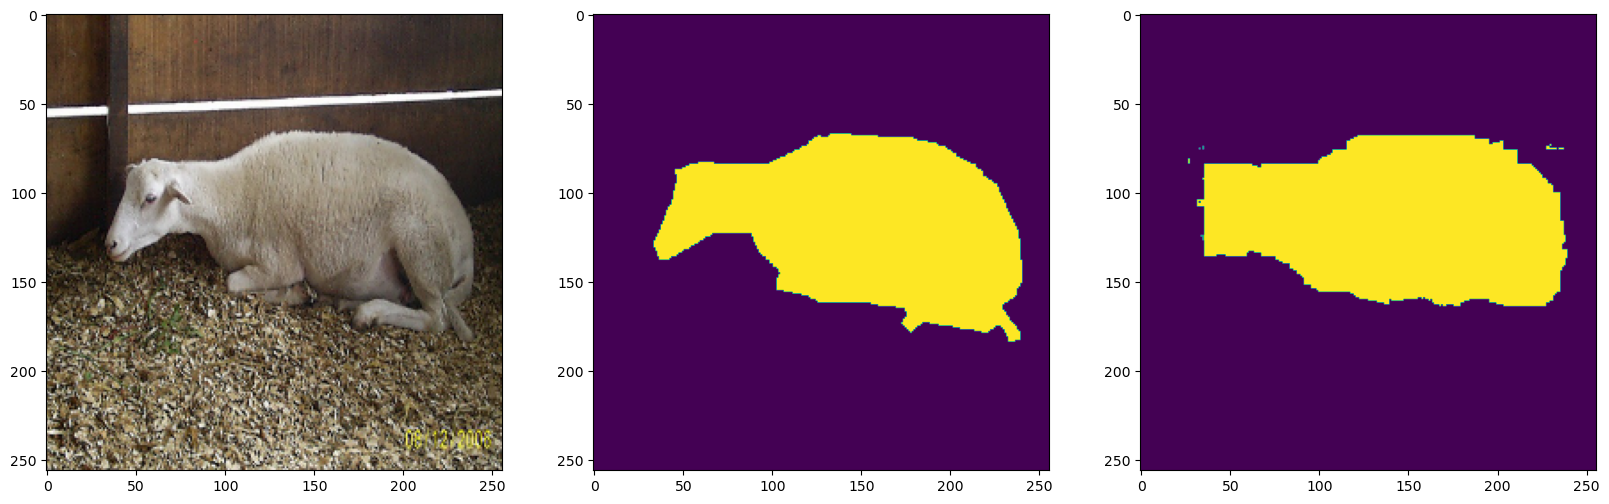

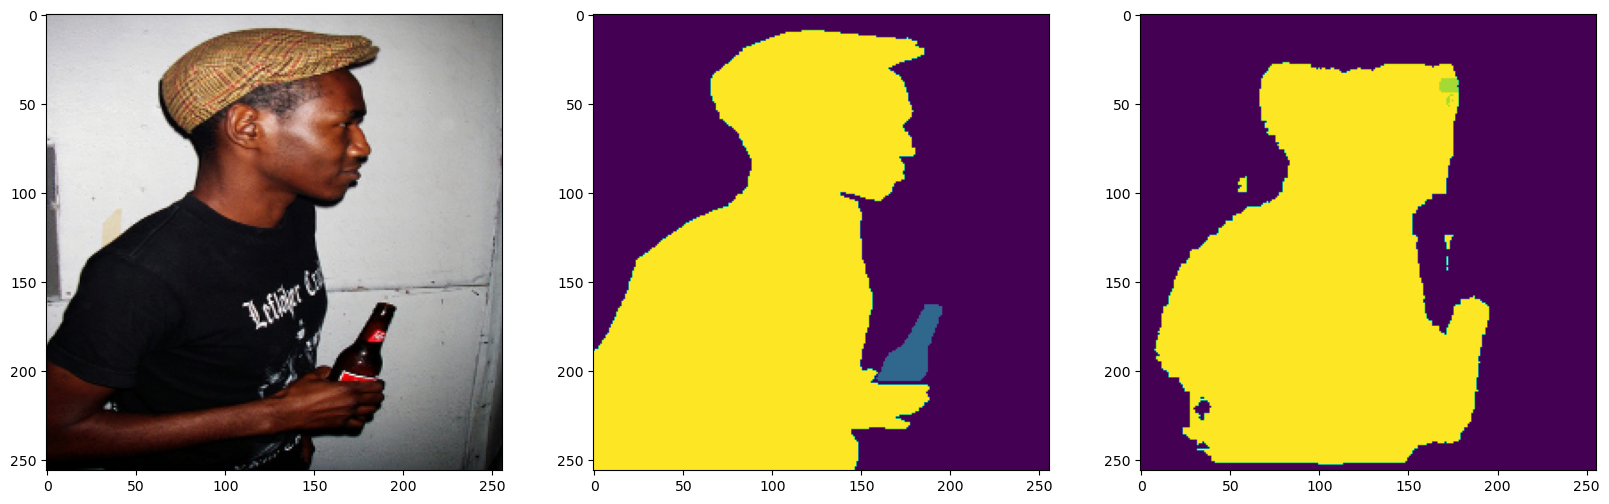

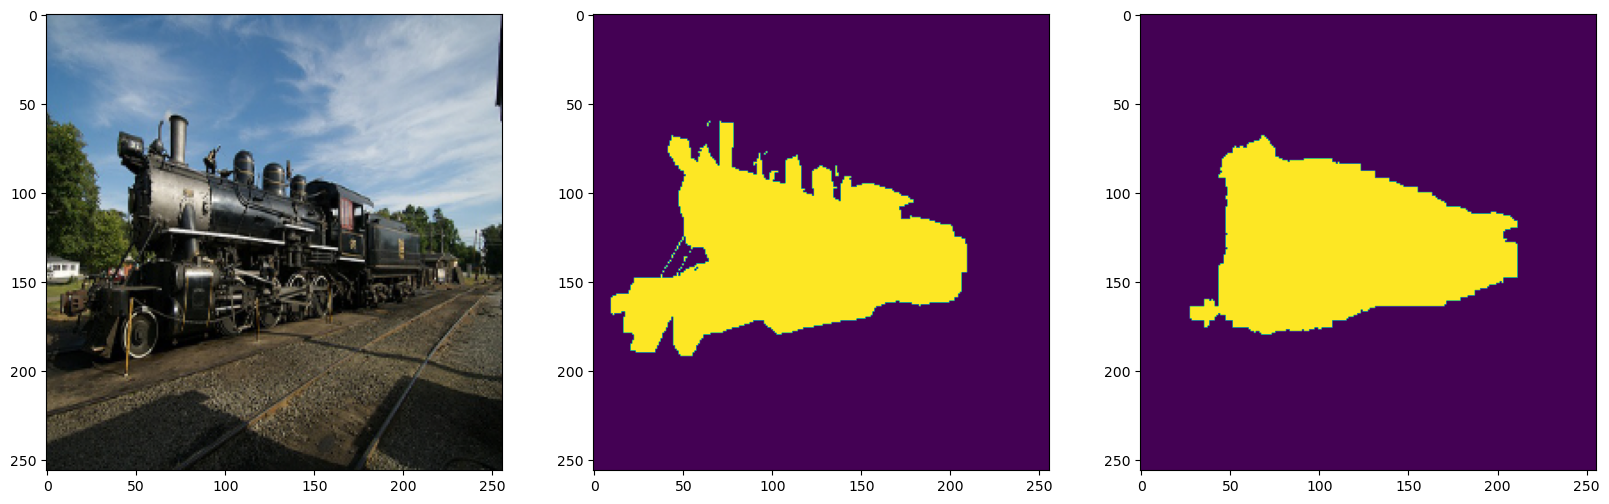

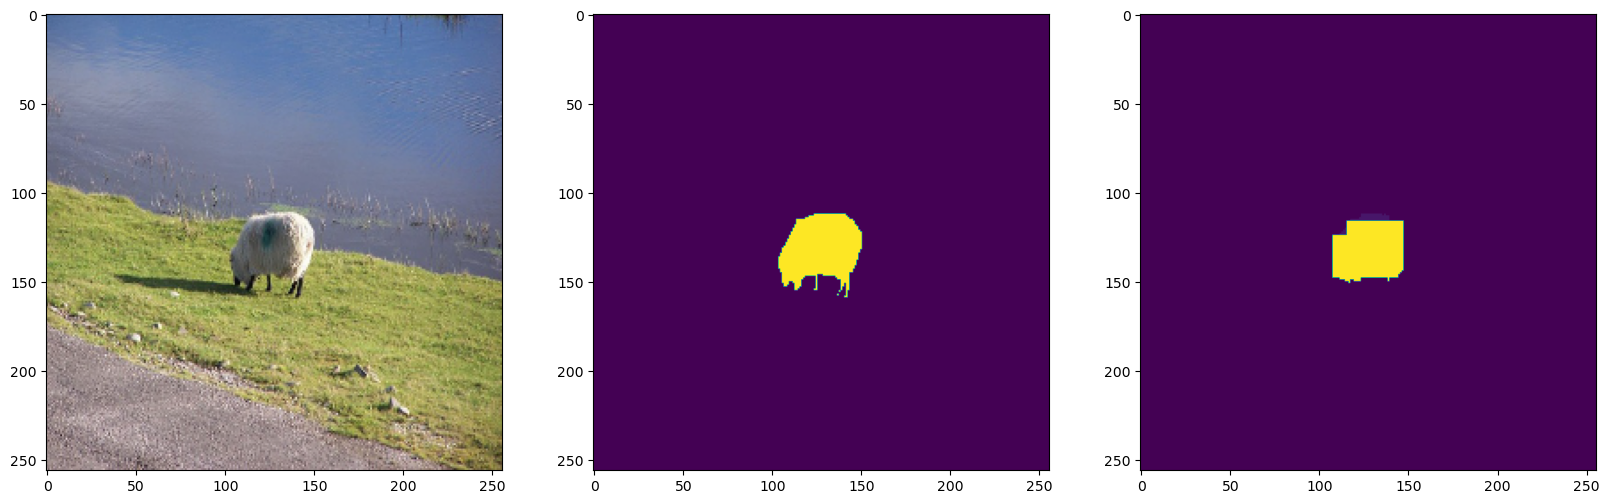

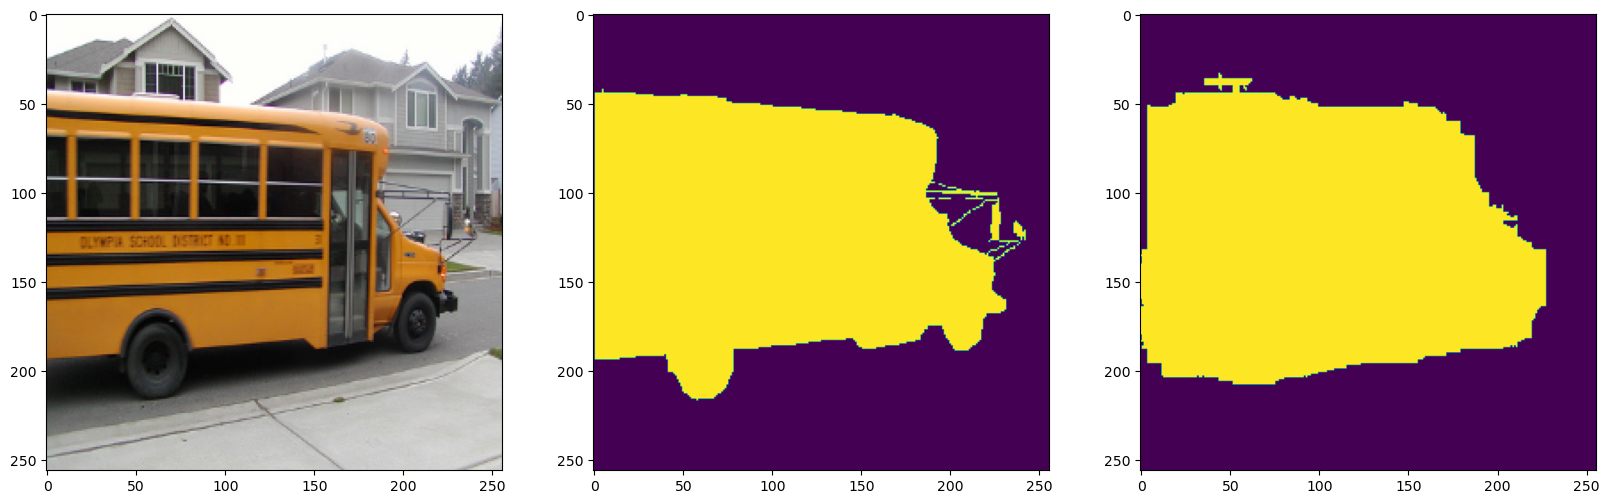

In [46]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model.to(device)
model.eval()

good_indices = [20, 31, 132, 160, 416]

with torch.no_grad():
  for idx in good_indices:

    images, mask = test_dataset[idx]
    images = images.unsqueeze(0).to(device)

    predictions = model(images)
    normalized_predictions = torch.nn.functional.softmax(predictions, dim=1)
    predictions = normalized_predictions.argmax(1).cpu().squeeze()
    
    iou_score = iou_pytorch(predictions.unsqueeze(0), mask.unsqueeze(0))
    image = images.cpu().squeeze()

    plt.figure(figsize=(20,20))
    img_r = re_normalize(image)
    plt.subplot(1,3,1)
    plt.imshow(to_pil_image(img_r))

    plt.subplot(1,3,2)
    plt.imshow(mask)

    plt.subplot(1,3,3)
    plt.imshow(predictions)
        